## Skymaps visualization

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    DiskSpatialModel,
)
from gammapy.irf import PSFMap, EDispKernelMap
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from gammapy.data import DataStore
from gammapy.datasets import MapDatasetEventSampler, MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker

### Load data
Putting all the data in a `DataStore` and selecting all the observations

In [8]:
data_store = DataStore.from_dir("../")
data_store.info()
observations = data_store.get_observations()
table = data_store.obs_table
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
print(pos_obs)

Data store:
HDU index table:
BASE_DIR: ..
Rows: 1080
OBS_ID: 0 -- 179
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 180

<SkyCoord (Galactic): (l, b) in deg
    [(64.49971954,  3.00063750e+00), (78.99824823,  1.50228951e+00),
     (73.49941027,  6.51251308e-04), (80.50044757, -5.96089509e-04),
     (80.50040631,  2.99951061e+00), (70.49985581,  2.15854807e-04),
     (70.49873969,  3.00223675e+00), (67.49936696,  1.16689918e-03),
     (78.99824823,  1.50228951e+00), (77.49961989,  3.00045604e+00),
     (67.49918078,  3.00135021e+00), (80.50040631,  2.99951061e+00),
     (80.50040631,  2.99951061e+00), (65.99850439,  1.50241276e+00),
     (73.49941027,  6.51251308e-04), (77.49932661,  8.28882955e-04),
     (71.99876709,  1.50162856e+00), (80.50044757, -5.96089509e-04),
     (78.99824823,  1.50228951e+00), (77.49961989,  3.00045604e+

## Map Geometry
Prepare the geometry "container" for the map

In [9]:
pos_target = SkyCoord(73.0, 2.0, frame='galactic', unit='deg')

energy_axis = MapAxis.from_bounds(
    0.7, 100, nbin=10, name="energy", unit="TeV", interp="log"
)
geom = WcsGeom.create(
    skydir=pos_target,
    axes=[energy_axis],
    width=[22 * u.deg, 12 * u.deg],
    binsz=0.03 * u.deg,
    frame="galactic",
)

### Compute images

In [10]:

stacked = MapDataset.create(geom=geom)
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "edisp", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])

for obs in observations:
    cutout = stacked.cutout(obs.pointing_radec, width="12 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)   

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0
No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1
No default upper safe energy threshold defined for obs 2
No default lower safe energy threshold defined for obs 2
No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3
No default upper safe energy threshold defined for obs 4
No default lower safe energy threshold defined for obs 4
No default upper safe energy threshold defined for obs 5
No default lower safe energy threshold defined for obs 5
No default upper safe energy threshold defined for obs 6
No default lower safe energy threshold defined for obs 6
No default upper safe energy threshold defined for obs 7
No default lower safe energy threshold defined for obs 7
No default upper safe energy threshold defined for obs 8
No default lower safe energy th

In [11]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = stacked.to_image()

### Show skymap

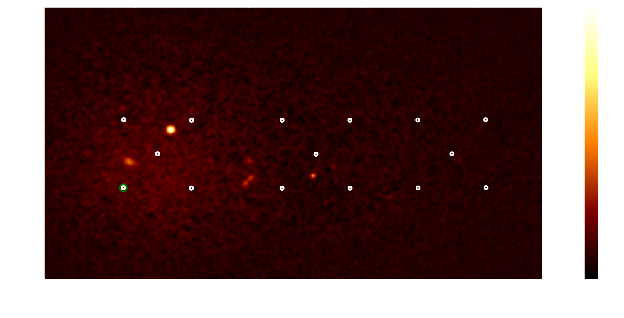

In [92]:
plt.figure(figsize=(15, 5))
ax = dataset_image.excess.smooth(2).plot(add_cbar=True)
ax.scatter(
    pos_obs.l.deg,
    pos_obs.b.deg,
    transform=plt.gca().get_transform("galactic"),
    color="none",
    edgecolor="white",
    marker="o",
    s=10,
    lw=1,
)
plt.show()

### Compute TS map

In [13]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-15 cm-2 s-1 TeV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

estimator = TSMapEstimator(
    model,
    kernel_width="0.1 deg",
    energy_edges=[0.7, 100] * u.TeV,
)
maps = estimator.run(stacked)

/home/antonio/Installed/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


### Show TS map

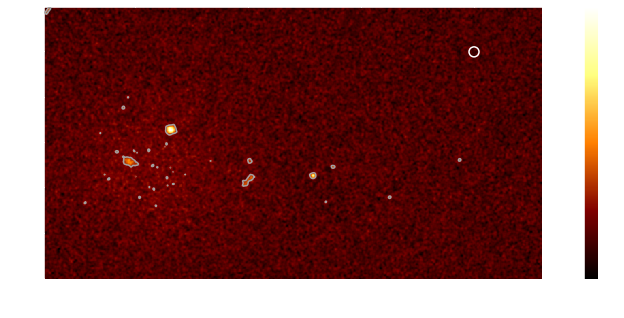

In [68]:
plt.figure(figsize=(15, 5))
maps["sqrt_ts"].plot(add_cbar=True)
cs = plt.contour(maps.sqrt_ts.data[0], levels=[5],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.changed()
plt.show()

### Create mask regions

In [15]:
mask_map_significance = maps["sqrt_ts"] > 5.0
invalid_pixels = np.isnan(maps["sqrt_ts"].data)
mask_map_significance.data[invalid_pixels] = True

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

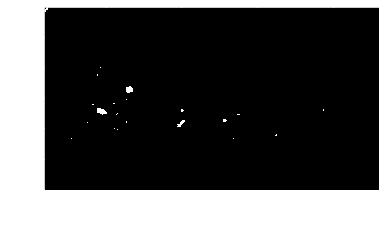

In [16]:
mask_map_significance.sum_over_axes().plot()

In [17]:
# To save masks to disk
mask_map_int = mask_map_significance.copy()
mask_map_int.data = mask_map_int.data.astype(int)
mask_map_int.write("exclusion_mask.fits", overwrite="True")
# To read maps from disk
#mask_map = Map.read("exclusion_mask.fits")
#mask_map.data = mask_map.data.astype(bool)